In [77]:
from __future__ import absolute_import ,division ,print_function
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd

import ROOT

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense,Lambda,multiply,Multiply,RepeatVector,Flatten,Concatenate,Dropout
from tensorflow.keras.models import Model

import tensorflow.keras.backend as K
from functools import partial

In [2]:
#K.set_session(tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=32, inter_op_parallelism_threads=4)))

In [3]:
n_particles = 100000/2
p = np.random.uniform(0.3,10.,int(n_particles))
mp = np.random.uniform(1/10.,1/0.3,int(n_particles))
p_mp = 1./mp 
p_ges = np.concatenate([p,p_mp])

In [4]:

mass_e = 0.000511
mass_mu = 0.105
mass_pi = 0.139
mass_K = 0.494
mass_p = 0.938
masses = [ mass_e,mass_mu, mass_pi, mass_K , mass_p]
masses

[0.000511, 0.105, 0.139, 0.494, 0.938]

In [5]:
signals = []
for mass in masses:
    ITS_tmp = []
    TPCROC0_tmp = []
    TPCROC1_tmp = []
    TPCROC2_tmp = []
    TRD_tmp = []
    TOF_tmp = []
    BBS_tmp = []
    BBA_tmp = []
    beta_tmp = []
    pmeas_tmp = []
    for p in p_ges:
        bg = p/mass
        beta = bg/math.sqrt(1.+ bg*bg);
        BBS = ROOT.AliExternalTrackParam.BetheBlochSolid(bg)
        BBA = ROOT.AliExternalTrackParam.BetheBlochAleph(bg)
        ITS_tmp.append(np.random.normal(BBS,0.1*BBS) ) ## ITS dEdx = smeared gaus 10% 
        TPCROC0_tmp.append(np.random.normal(BBA,0.1*BBA) )## TPC dEdx = smeared gaus 10% for 1st layer
        TPCROC1_tmp.append(np.random.normal(BBA,0.1*BBA) )  ## TPC dEdx = smeared gaus 10% for 2nd layer
        TPCROC2_tmp.append(np.random.normal(BBA,0.1*BBA) )  ## TPC dEdx = smeared gaus 10% for 3d layer
        TRD_tmp.append(np.random.normal(BBA,0.1*BBA) )  ## TRD dEdx = smeared gaus 10% 
        TOF_tmp.append(np.random.normal(beta,0.01*beta) )  ## TOF - smeared with .... gaussian
        pmeas_tmp.append(np.random.normal(p,0.01*p))
        BBS_tmp.append(BBS)
        BBA_tmp.append(BBA)
        beta_tmp.append(beta)
        
    signals.append({'ITS': ITS_tmp, 'TPCROC0': TPCROC0_tmp, 'TPCROC1': TPCROC1_tmp, 'TPCROC1': TPCROC1_tmp, 
                    'TPCROC2': TPCROC2_tmp, 'TRD': TRD_tmp, 'TOF': TOF_tmp, 'BBS': BBS_tmp, 'BBA': BBA_tmp, "beta": beta_tmp,
                   "pmeas": pmeas_tmp})

In [6]:
df_list=[]
for i, val in enumerate(masses):
    df = pd.DataFrame.from_dict(signals[i])
    df['p'] = pd.Series(p_ges, index=df.index)
    df['particle'] = pd.Series(i, index=df.index)
    df_list.append(df)
df_all = pd.concat([df_list[0],df_list[2],df_list[3],df_list[4]], ignore_index=True)

In [7]:
m_inv  = np.array([1./mass_e,1./mass_mu,1./mass_pi,1./mass_K,1./mass_p])
bg     = np.log(pd.DataFrame(m_inv[df_all["particle"]]*df_all["p"]))
bg.columns=['lnbg']
df_all = pd.concat([df_all,bg], axis = 1).sample(frac=1)
df_all.head(10)

,BBA,BBS,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD,beta,pmeas,p,particle,lnbg
150121,1.009932,0.001695,0.001786,0.917542,1.274852,0.840731,1.007960,1.140268,0.928474,0.350016,0.347494,2,0.916273
110411,1.357381,0.002144,0.002430,1.003232,1.261072,1.533582,1.391559,1.475200,0.999893,9.311976,9.514313,2,4.226079
296117,1.249700,0.002120,0.002281,0.785834,1.271234,1.122534,1.435631,1.398750,0.785309,0.616054,0.626620,3,0.237805
137735,1.037445,0.001720,0.001842,0.986914,1.009265,1.091373,0.986316,1.045504,0.988812,0.919617,0.921418,2,1.891439
272726,1.585535,0.002713,0.002406,0.665206,1.572744,1.521864,1.800174,1.453122,0.673737,0.457594,0.450391,3,-0.092419
274027,2.368211,0.004119,0.004287,0.523665,2.227937,2.397992,3.090590,2.351721,0.526056,0.304273,0.305569,3,-0.480358
371626,1.381112,0.002351,0.002272,0.743287,1.303979,1.509667,1.153008,1.526002,0.735432,1.013982,1.018059,4,0.081903
164534,1.024297,0.001701,0.001708,1.007555,1.142173,1.124999,0.906024,1.060808,0.985504,0.804611,0.807446,2,1.759402
331259,2.749850,0.004812,0.005082,0.475447,2.452122,2.664223,2.745553,3.045199,0.480202,0.506792,0.513510,4,-0.602481
169810,0.995558,0.001666,0.001758,0.962331,1.119936,0.915253,0.957817,0.920843,0.953691,0.441819,0.440720,2,1.153935


[]

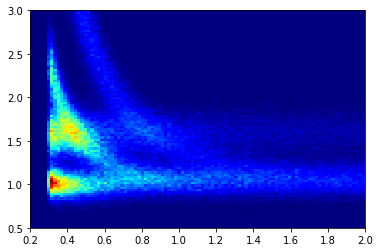

In [8]:
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.plot()

[]

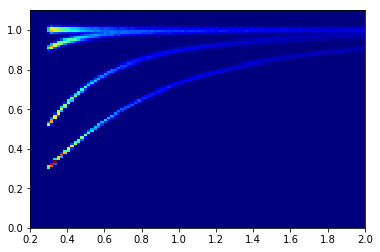

In [9]:
plt.hist2d(df_all["p"], df_all["TOF"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.0, 1.1]])
plt.plot()

In [10]:
def BetheBlochAlephNP(lnbg,kp1=0.76176e-1,kp2=10.632,kp3=0.13279e-4,kp4=1.8631,kp5=1.9479):
    bg   = np.exp(lnbg)
    beta = bg/np.sqrt(1.+ bg*bg)
    aa   = np.exp(kp4*np.log(beta))
    bb   = np.exp(-kp5*np.log(bg))
    bb   = np.log(kp3+bb)
    return (kp2-aa-bb)*kp1/aa

def BetheBlochGeantNP(lnbg,kp0=2.33,kp1=0.20,kp2=3.00,kp3=173e-9,kp4=0.49848):
    bg   = np.exp(lnbg)
    mK  = 0.307075e-3
    me  = 0.511e-3
    rho = kp0
    x0  = kp1*2.303
    x1  = kp2*2.303
    mI  = kp3
    mZA = kp4
    bg2 = bg*bg
    maxT= 2*me*bg2
    
    d2=0.
    x=np.log(bg)
    lhwI=np.log(28.816*1e-9*np.sqrt(rho*mZA)/mI)
    if x>x1 :
        d2 = lhwI + x - 0.5
    else :
        if x>x0:
            r=(x1-x)/(x1-x0)
            d2 = lhwI + x - 0.5 + (0.5 - lhwI - x0)*r*r*r
        
    return mK*mZA*(1+bg2)/bg2*(0.5*np.log(2*me*bg2*maxT/(mI*mI)) - bg2/(1+bg2) - d2)

def BetheBlochSolidNP(lnbg):
    return BetheBlochGeantNP(lnbg)

In [11]:

def BetheBlochAleph(lnbg,kp1=0.76176e-1,kp2=10.632,kp3=0.13279e-4,kp4=1.8631,kp5=1.9479):
    bg   = K.exp(lnbg)
    beta = bg/K.sqrt(1.+ bg*bg)
    aa   = K.exp(kp4*K.log(beta))
    bb   = K.exp(-kp5*K.log(bg))
    bb   = K.log(kp3+bb)
    return (kp2-aa-bb)*kp1/aa


def BetheBlochGeant(lnbg,kp0=2.33,kp1=0.20,kp2=3.00,kp3=173.0e-9,kp4=0.49848):
    bg=K.exp(lnbg)
    mK  = 0.307075e-3
    me  = 0.511e-3
    rho = kp0
    x0  = kp1*2.303
    x1  = kp2*2.303
    mI  = kp3
    mZA = kp4
    bg2 = bg*bg
    maxT= 2*me*bg2
    
    
    x=lnbg
    lhwI=K.log(28.816e-9*K.sqrt(K.cast(rho*mZA,dtype=float))/mI)

    d2=K.switch(K.greater(x,x1),lhwI + x - 0.5,
               K.switch(K.greater(x,x0),lhwI + x - 0.5 + (0.5 - lhwI - x0)*(((x1-x)/(x1-x0))**3),0.*bg))
        
    return mK*mZA*(1+bg2)/bg2*(0.5*K.log(2*me*bg2*maxT/(mI*mI)) - bg2/(1+bg2) - d2)

    
def BetheBlochSolid(lnbg):
    return BetheBlochGeant(lnbg)

def getbeta(lnbg):
    bg   = K.exp(lnbg)
    return bg/K.sqrt(1.+ bg*bg)


In [12]:


def custom_loss(y_true, y_pred):

    d = (y_true - y_pred)/ y_true 
    d0=d[:,0]
    d1=d[:,1]*10
    d2=d[:,2]
    d3=d[:,3]
    d4=d[:,4]
    d5=d[:,5]
    d=d0*d0+d1*d1+d2*d2+d3*d3+d4*d4+d5*d5

    return d/6.

inputs = Input(shape=(7,))
enc    = Dense(units=64, activation='selu')(inputs)
enc    = Dense(units=64, activation='selu')(enc)
enc    = Dense(units=64, activation='selu')(enc)
#enc    = Dense(units=64, activation='selu')(enc)

gb     = Dense(units=1, activation='linear')(enc)

BBA    = Lambda(BetheBlochAleph)(gb)
BBA4   = RepeatVector(4)(BBA)
BBA4    = Flatten()(BBA4) 
BBS    = Lambda(BetheBlochSolid)(gb)
TOF    = Lambda(getbeta)(gb)
final  = Concatenate(axis=-1)([BBS,TOF,BBA4])

modelgb= Model(inputs=inputs,outputs=gb)
modelBB= Model(inputs=inputs,outputs=BBA)
modelBS= Model(inputs=inputs,outputs=BBS)
modelTF= Model(inputs=inputs,outputs=TOF)
modelfi= Model(inputs=inputs,outputs=final)

modelfi.compile(loss=custom_loss,optimizer='adam',metrics=['mse'])
modelgb.compile(loss='mse',optimizer='adam',metrics=['mse'])

In [13]:
modelfi.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 7)            0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           512         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           4160        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           4160        dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (D

In [14]:
modelgb.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 64)                512       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 8,897
Trainable params: 8,897
Non-trainable params: 0
_________________________________________________________________


In [15]:
modelBB.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 64)                512       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0         
Total params: 8,897
Trainable params: 8,897
Non-trainable params: 0
_________________________________________________________________


In [16]:
train, test =train_test_split(df_all, test_size=0.5)
train_data = train[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD","p"]]
test_data  = test[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD","p"]]

train_fdata= train[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]
test_fdata = test[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]

train_gb   = train[["lnbg"]]
test_gb    = test[["lnbg"]]

In [17]:
# take scaler from unmodified values ?
scaler = StandardScaler()
scaler.fit(train[["ITS","TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD","p"]])



StandardScaler(copy=True, with_mean=True, with_std=True)

In [18]:
#modelgb.fit(scaler.transform(train_data),train_gb, epochs=10, batch_size=64, 
#          validation_data=[scaler.transform(test_data),test_gb])

In [19]:
modelfi.fit(scaler.transform(train_data),train_fdata, epochs=12, batch_size=128, 
          validation_data=[scaler.transform(test_data),test_fdata])

Train on 200000 samples, validate on 200000 samples
Epoch 1/12
200000/200000 [==============================] - 17s 86us/step - loss: 0.0381 - mean_squared_error: 0.0545 - val_loss: 0.0175 - val_mean_squared_error: 0.0299
Epoch 2/12
200000/200000 [==============================] - 16s 80us/step - loss: 0.0138 - mean_squared_error: 0.0224 - val_loss: 0.0104 - val_mean_squared_error: 0.0177
Epoch 3/12
200000/200000 [==============================] - 16s 79us/step - loss: 0.0119 - mean_squared_error: 0.0199 - val_loss: 0.0147 - val_mean_squared_error: 0.0242
Epoch 4/12
200000/200000 [==============================] - 16s 79us/step - loss: 0.0109 - mean_squared_error: 0.0187 - val_loss: 0.0107 - val_mean_squared_error: 0.0193
Epoch 5/12
200000/200000 [==============================] - 16s 78us/step - loss: 0.0111 - mean_squared_error: 0.0191 - val_loss: 0.0096 - val_mean_squared_error: 0.0176
Epoch 6/12
200000/200000 [==============================] - 16s 78us/step - loss: 0.0103 - mean_sq

2019-02-05 16:24:40.493888: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: FMA


In [20]:
out=modelfi.predict(scaler.transform(test_data))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
ogb=(modelgb.predict(scaler.transform(test_data)))
GB_predict = pd.DataFrame(ogb)
GB_predict.columns = ["gb_ae"]
test = test.reset_index()
df_test = pd.concat([test,AE_predict,GB_predict], axis = 1)
df_test.head()

,index,BBA,BBS,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD,beta,...,p,particle,lnbg,ITS_ae,TOF_ae,TPCROC0_ae,TPCROC1_ae,TPCROC2_ae,TRD_ae,gb_ae
0,259049,1.166028,0.001975,0.002483,0.825769,1.501554,1.131137,1.124037,1.175322,0.823569,...,0.717263,3,0.372907,0.001961,0.827636,1.157947,1.157947,1.157947,1.157947,0.388378
1,156209,0.996381,0.001664,0.001757,0.967556,0.851916,0.974375,1.139533,1.033582,0.966375,...,0.522392,2,1.323944,0.001664,0.966604,0.996476,0.996476,0.996476,0.996476,1.327537
2,270515,1.644202,0.002817,0.003038,0.646467,2.054091,1.880971,1.870562,1.642568,0.658599,...,0.432359,3,-0.133279,0.002952,0.640508,1.719436,1.719436,1.719436,1.719436,-0.181465
3,54492,1.583340,0.002598,0.003038,1.005662,1.395043,1.545045,1.296612,1.391856,1.000000,...,0.599695,0,7.067807,0.002594,1.000000,1.583088,1.583088,1.583088,1.583088,7.045061
4,388734,5.509860,0.009888,0.008638,0.320012,5.201428,5.381489,5.620255,5.096229,0.314096,...,0.310327,4,-1.106124,0.009765,0.316451,5.443149,5.443149,5.443149,5.443149,-1.097828


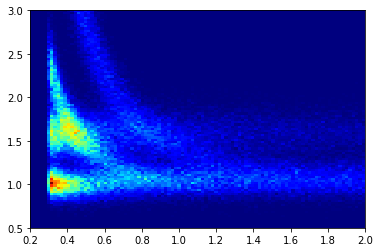

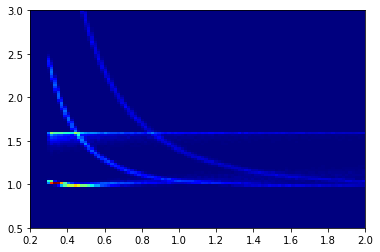

In [21]:
plt.hist2d(df_test["p"], df_test["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test["p"], df_test["TPCROC1_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()


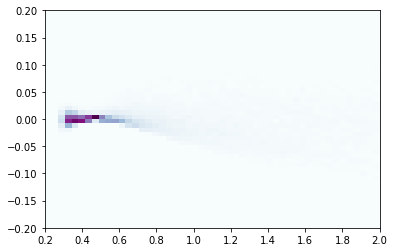

In [43]:
particle_id = 2
delta=df_test.query("particle==" + str(particle_id))["TPCROC1_ae"]-df_test.query("particle==" + str(particle_id))["BBA"]
plt.hist2d(df_test.query("particle==" + str(particle_id))["p"],delta, bins=(50, 50), range = [[0.2, 2], [-0.2, 0.2]], cmap=plt.cm.BuPu)
plt.show()

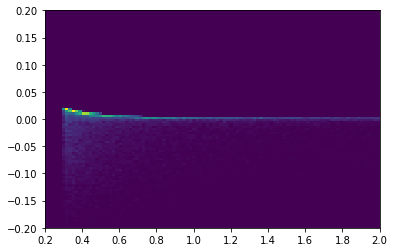

In [23]:
particle_id = 0
delta=df_test.query("particle==" + str(particle_id))["TPCROC1_ae"]-df_test.query("particle==" + str(particle_id))["BBA"]
plt.hist2d(df_test.query("particle==" + str(particle_id))["p"],delta, bins=(100, 100), range = [[0.2, 2], [-0.2, 0.2]])
plt.show()

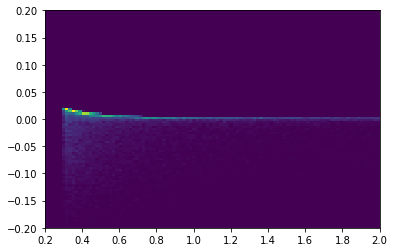

In [32]:
particle_id = 0
delta=df_test.query("particle==" + str(particle_id))["TPCROC1_ae"]-df_test.query("particle==" + str(particle_id))["BBA"]
plt.hist2d(df_test.query("particle==" + str(particle_id))["p"],delta, bins=(100, 100), range = [[0.2, 2], [-0.2, 0.2]])
plt.show()

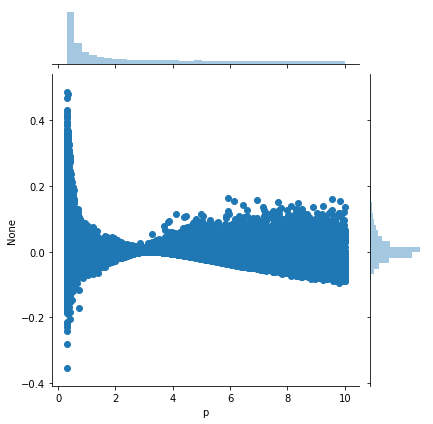

In [80]:
particle_id = 4
delta=df_test.query("particle==" + str(particle_id))["TPCROC1_ae"]-df_test.query("particle==" + str(particle_id))["BBA"]
momentum = df_test.query("particle==" + str(particle_id))["p"]
sns.jointplot(momentum, delta)
#plt.hist2d(momentum,delta, bins=(100, 100), range = [[0.2, 2], [-0.2, 0.2]], cmap=plt.cm.BuPu)
#plt.show()

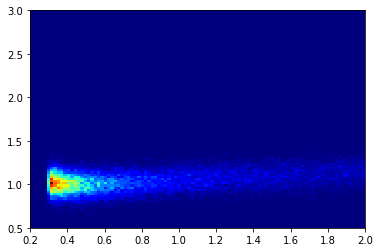

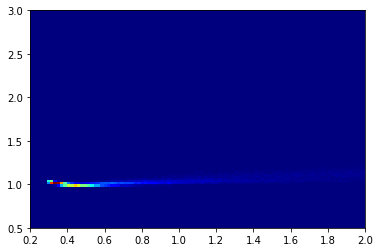

In [26]:
particle_id = 2
plt.hist2d(df_test.query("particle==" + str(particle_id))["p"], df_test.query("particle==" + str(particle_id))["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test.query("particle==" + str(particle_id))["p"], df_test.query("particle==" + str(particle_id))["TPCROC1_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()


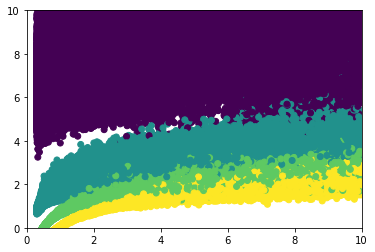

In [27]:
#plt.yscale('log')
plt.axis([0.,10.,0.,10.])
plt.scatter(df_test["p"],df_test["gb_ae"],c=df_test["particle"])
plt.show()

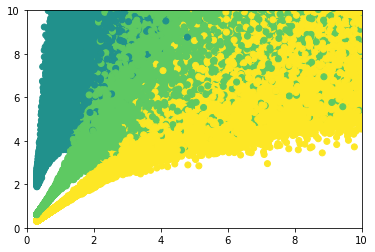

In [28]:
#plt.yscale('log')
plt.axis([0.,10.,0.,10.])
plt.scatter(df_test["p"],np.exp(df_test["gb_ae"]),c=df_test["particle"])
plt.show()

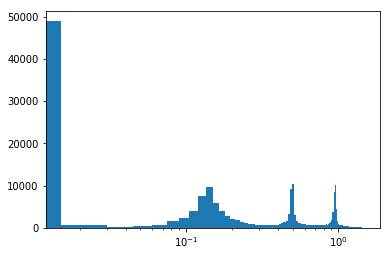

In [36]:

plt.hist(df_test["p"]/np.exp(df_test["gb_ae"]),bins=100, range=[0,1.5])
plt.xscale('log')

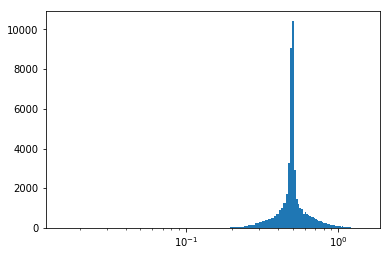

In [38]:
particle_id = 3
plt.hist(df_test.query("particle==" + str(particle_id))["p"]/np.exp(df_test.query("particle==" + str(particle_id))["gb_ae"]),bins=100, range=[0,1.5])
plt.xscale('log')

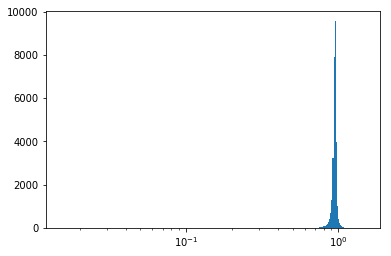

In [33]:
particle_id = 4
plt.hist(df_test.query("particle==" + str(particle_id)+ "and p>0.2 and p < 3.")["p"]/np.exp(df_test.query("particle==" + str(particle_id)+ "and p>0.2 and p < 3.")["gb_ae"]),bins=100, range=[0,1.5])
plt.xscale('log')

In [69]:
from sklearn.ensemble import RandomForestClassifier

In [70]:
RF = RandomForestClassifier(n_estimators=150, max_depth = 15, n_jobs=30)
RF2 = RandomForestClassifier(n_estimators=150, max_depth = 15, n_jobs=30)

In [71]:
RFtrain, RFtest = train_test_split(df_test,test_size=0.5)

In [72]:
RF.fit(RFtrain[["ITS","TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD","p"]], np.ravel(RFtrain[["particle"]]))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=30,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [73]:
RF.score(RFtest[["ITS","TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD","p"]], np.ravel(RFtest[["particle"]]))

0.94899

In [74]:
RF2.fit(RFtrain[["ITS_ae","TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae","p"]], np.ravel(RFtrain[["particle"]]))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=30,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [75]:
RF2.score(RFtest[["ITS_ae","TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae","p"]], np.ravel(RFtest[["particle"]]))

0.94881